# Ultrasonic Data Feature Engineering

Export sensor data 1-6 and merge them and fill up NaNs

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px



In [6]:
def get_all_files_in_directory(root_directory):
    file_paths = []
    for root, dirs, files in os.walk(root_directory):
        for file in files:
            file_paths.append(os.path.join(root, file))
    return file_paths


def merge_csv_files(file_paths):
    """
    Merge multiple CSV files into a single DataFrame.

    Parameters:
    file_paths (list of str): List of file paths to the CSV files.

    Returns:
    DataFrame: Merged DataFrame containing data from all input CSV files.
    """
    dataframes = []
    for file in file_paths:
        df = pd.read_csv(file)
        dataframes.append(df)

    # Concatenate all DataFrames
    merged_df = pd.concat(dataframes, ignore_index=True)
    
    return merged_df

## Import data

Currently there are 20 sensor datas.

In [12]:
folder_path = '../../ultra_sonic_sensor/fully_automate/data_v4.1.1'
file_paths = get_all_files_in_directory(folder_path)
df_data_v4_1_1 = merge_csv_files(file_paths)
df_data_v4_1_1

,Trial,Ping Duration,Distance (cm),Ping Time (us),Delay (us),Steps,Arduino ID,Sensor ID,Range (cm),Sensor length (cm),...,Angle on XY plane,side a (cm),side b (cm),side c (cm),Angle on YZ plane,Sensor Configuration,Sensor Angle,Surface material,Surface Length (cm),Surface Width (cm)
0,0,1680,13.39,763,16800,12576.0,1,32,13,0.8,...,0,18.3,18.3,0,0,HTR,90,wood,31,30.5
1,1,1664,13.46,767,16800,12576.0,1,32,13,0.8,...,0,18.3,18.3,0,0,HTR,90,wood,31,30.5
2,2,1672,13.46,767,16800,12576.0,1,32,13,0.8,...,0,18.3,18.3,0,0,HTR,90,wood,31,30.5
3,3,1664,13.39,763,16800,12576.0,1,32,13,0.8,...,0,18.3,18.3,0,0,HTR,90,wood,31,30.5
4,4,1664,13.46,767,16800,12576.0,1,32,13,0.8,...,0,18.3,18.3,0,0,HTR,90,wood,31,30.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143926,45,20300,0.00,0,3000,0.0,1,75,53,0.8,...,0,18.3,18.3,0,0,HTR,90,wood,31,30.5
143927,46,8240,52.33,2983,3000,0.0,1,75,53,0.8,...,0,18.3,18.3,0,0,HTR,90,wood,31,30.5
143928,47,20300,0.00,0,3000,0.0,1,75,53,0.8,...,0,18.3,18.3,0,0,HTR,90,wood,31,30.5
143929,48,8240,52.33,2983,3000,0.0,1,75,53,0.8,...,0,18.3,18.3,0,0,HTR,90,wood,31,30.5


In [16]:
# Step 1: Identify Columns with NaNs
nan_columns = df_data_v4_1_1.columns[df_data_v4_1_1.isnull().any()]

# Step 2: Find Mode and Replace NaNs
for col in nan_columns:
    if df_data_v4_1_1[col].dtype == object:  # Check if the column is categorical
        mode_value = df_data_v4_1_1[col].mode()[0]  # Find the mode value (most frequent value)\
        df_data_v4_1_1[col].fillna(mode_value, inplace=True)  # Replace NaNs with the mode value

In [17]:
values_to_keep = [16800,10000,8000,6000,3000]
df_data_v4_1_1 = df_data_v4_1_1[df_data_v4_1_1["Delay (us)"].isin(values_to_keep)]

## IQR based feature engineering: Range_delay

Helper codes

In [18]:
def identify_and_remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_no_outliers = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    df_outliers_lower = df[(df[column] <= lower_bound)]
    df_outliers_upper = df[(df[column] >= upper_bound)]
    return df_no_outliers,df_outliers_lower,df_outliers_upper

def split_quartiles(df):
    # Group the data by 'Sensor ID', 'Delay (us)', and 'Range (cm)'
    df_copy = df.copy()
    grouped = df_copy.groupby(['Sensor ID', 'Delay (us)', 'Range (cm)'])

    # Identify and remove outliers for each group
    middle_quartile = []
    lower_quartile = []
    upper_quartile = []

    for name, group in grouped:
        cleaned_group = group.copy()
        for column in ['Ping Time (us)']:
            middle_quartile_group,lower_quartile_group,upper_quartile_group = identify_and_remove_outliers(cleaned_group, column)
        middle_quartile.append(middle_quartile_group)
        lower_quartile.append(lower_quartile_group)
        upper_quartile.append(upper_quartile_group)
    # Combine the cleaned groups into a single DataFrame
    df_middle_quartile= pd.concat(middle_quartile)
    df_lower_quartile = pd.concat(lower_quartile)
    df_upper_quartile = pd.concat(upper_quartile)
    
    return df_middle_quartile, df_lower_quartile, df_upper_quartile


def create_range_delay_feature(df_quartile,bound):
    # Step 1: Group and calculate mean
    df_grouped = df_quartile.groupby(['Sensor ID', 'Range (cm)', 'Delay (us)'])['Ping Time (us)'].mean().reset_index()

    # Step 2: Create `range_delay` column
    df_grouped['range_delay'] = df_grouped['Range (cm)'].astype(str) + '_' + df_grouped['Delay (us)'].astype(str)+'_'+bound

    # Step 3: Pivot the table
    df_pivot = df_grouped.pivot(index='Sensor ID', columns='range_delay', values='Ping Time (us)').reset_index()
    
    return df_pivot

In [19]:
df_middle_quartile, df_lower_quartile, df_upper_quartile = split_quartiles(df_data_v4_1_1)

In [20]:
df_middle_quartile.groupby(['Sensor ID','Range (cm)', 'Delay (us)'])['Ping Time (us)'].mean().reset_index(["Delay (us)","Range (cm)"])

,Range (cm),Delay (us),Ping Time (us)
Sensor ID,,,
32,13,3000,765.640000
32,13,6000,765.560000
32,13,8000,766.120000
32,13,10000,765.626263
32,13,16800,765.693878
...,...,...,...
75,53,3000,1490.540000
75,53,6000,2981.880000
75,53,8000,2981.800000


In [21]:
create_range_delay_feature(df_middle_quartile,"middle")

range_delay,Sensor ID,13_10000_middle,13_16800_middle,13_3000_middle,13_6000_middle,13_8000_middle,18_10000_middle,18_16800_middle,18_3000_middle,18_6000_middle,...,48_10000_middle,48_16800_middle,48_3000_middle,48_6000_middle,48_8000_middle,53_10000_middle,53_16800_middle,53_3000_middle,53_6000_middle,53_8000_middle
0,32,765.626263,765.693878,765.640000,765.560000,766.120000,1057.280000,821.200000,1057.626263,1057.440000,...,2765.200000,2771.200000,2765.315789,2765.520000,2765.160000,3090.111111,3088.120000,3090.480000,3089.560000,3090.000000
1,33,755.000000,779.530612,736.640000,779.275862,755.467532,1024.818182,1035.640000,1024.777778,1025.720000,...,2725.800000,2726.920000,2739.000000,2729.600000,2729.040000,3040.480000,3016.896907,3042.000000,3047.571429,3049.026667
2,34,665.680000,658.920000,675.989247,653.682353,665.240000,969.480000,969.469136,969.520000,969.585859,...,2641.160000,2640.979798,2643.360000,2642.040000,2641.480000,2941.040000,2940.920000,2944.301205,2939.960000,2948.090909
3,35,861.640000,861.626263,804.320000,861.840000,863.000000,1012.333333,1011.800000,1012.720000,1012.240000,...,2755.000000,2777.813187,2755.000000,2777.595745,2755.418605,3014.760000,3015.720000,3029.800000,3029.813187,3017.120000
4,36,743.520000,743.962025,743.360000,743.680000,743.600000,1067.000000,1054.880000,1064.494949,1067.000000,...,2770.083333,2753.960000,2763.160000,2754.680000,2769.608696,3085.712644,3077.440000,3043.560000,3047.903226,1856.680000
5,37,739.808081,597.240000,739.727273,739.760000,739.929293,975.646465,975.547368,984.840000,975.757895,...,2719.000000,323.106667,2719.000000,2719.186047,2719.525253,3047.848485,383.789474,3019.000000,3018.172414,405.590909
6,38,752.320000,753.400000,752.720000,753.280000,753.720000,1067.800000,1075.960000,1102.360000,1101.666667,...,2725.666667,2719.808511,2718.320000,2719.240000,2725.461538,3053.595745,3035.280000,3014.182796,3014.000000,421.808511
7,39,865.989899,867.000000,867.000000,865.600000,864.840000,1071.000000,1071.000000,1071.000000,1071.000000,...,2694.440000,2695.134831,2695.000000,2695.000000,2695.000000,2991.000000,2991.512821,2991.000000,2995.742268,2991.000000
8,40,738.200000,728.619048,728.960000,728.880000,728.960000,1041.585859,1039.638298,1040.200000,1039.000000,...,2763.000000,2739.000000,2762.789474,2751.808989,2762.951220,3027.680000,3031.000000,3040.440000,3009.368421,3023.600000
9,41,721.840000,739.040000,721.960000,721.682353,722.120000,1028.080000,1034.753086,1037.382022,1010.946667,...,2728.090909,2730.440000,2736.160000,2728.241379,2728.118280,3028.217391,3018.840000,3027.000000,3027.000000,3028.113924


In [24]:
def feature_engineering_quartile_means(df):
    df_middle_quartile, df_lower_quartile, df_upper_quartile = split_quartiles(df)
    df_range_delay_middle = create_range_delay_feature(df_middle_quartile,"middle")
    df_range_delay_lower = create_range_delay_feature(df_lower_quartile,"lower")
    df_range_delay_upper = create_range_delay_feature(df_upper_quartile,"upper")

    # List of DataFrames
    df_pivots = [df_range_delay_middle, df_range_delay_lower, df_range_delay_upper]

    # Initialize the merged DataFrame with the first DataFrame in the list
    df_range_delay_all = df_pivots[0]

    # Iteratively merge each DataFrame in the list
    for df in df_pivots[1:]:
        df_range_delay_all = df_range_delay_all.merge(df, on='Sensor ID')
        
    # Replace all NaN values with 0 in the merged DataFrame
    df_range_delay_all.fillna(0, inplace=True)

    return df_range_delay_all, df_range_delay_middle, df_range_delay_lower,df_range_delay_upper
    

df_range_delay_all,df_range_delay_middle, df_range_delay_lower,df_range_delay_upper = feature_engineering_quartile_means(df_data_v4_1_1)


The product is following now we will be conducting PCA method to reduce dimensionality

In [25]:
df_range_delay_all

range_delay,Sensor ID,13_10000_middle,13_16800_middle,13_3000_middle,13_6000_middle,13_8000_middle,18_10000_middle,18_16800_middle,18_3000_middle,18_6000_middle,...,48_10000_upper,48_16800_upper,48_3000_upper,48_6000_upper,48_8000_upper,53_10000_upper,53_16800_upper,53_3000_upper,53_6000_upper,53_8000_upper
0,32,765.626263,765.693878,765.640000,765.560000,766.120000,1057.280000,821.200000,1057.626263,1057.440000,...,0.000000,0.000000,2787.833333,0.000000,0.000000,3099.000000,0.000000,0.000000,0.000000,0.000000
1,33,755.000000,779.530612,736.640000,779.275862,755.467532,1024.818182,1035.640000,1024.777778,1025.720000,...,0.000000,0.000000,2740.037037,0.000000,0.000000,0.000000,3073.666667,0.000000,3073.400000,3074.000000
2,34,665.680000,658.920000,675.989247,653.682353,665.240000,969.480000,969.469136,969.520000,969.585859,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,35,861.640000,861.626263,804.320000,861.840000,863.000000,1012.333333,1011.800000,1012.720000,1012.240000,...,2758.652174,0.000000,2756.839080,0.000000,2778.428571,0.000000,0.000000,0.000000,0.000000,0.000000
4,36,743.520000,743.962025,743.360000,743.680000,743.600000,1067.000000,1054.880000,1064.494949,1067.000000,...,2779.000000,0.000000,0.000000,0.000000,0.000000,3113.000000,0.000000,0.000000,0.000000,0.000000
5,37,739.808081,597.240000,739.727273,739.760000,739.929293,975.646465,975.547368,984.840000,975.757895,...,2720.523810,2679.000000,2720.063291,2743.285714,2743.000000,3075.000000,3046.666667,3020.100000,3041.153846,2241.333333
6,38,752.320000,753.400000,752.720000,753.280000,753.720000,1067.800000,1075.960000,1102.360000,1101.666667,...,0.000000,0.000000,0.000000,0.000000,0.000000,3063.000000,0.000000,0.000000,0.000000,1862.333333
7,39,865.989899,867.000000,867.000000,865.600000,864.840000,1071.000000,1071.000000,1071.000000,1071.000000,...,0.000000,2719.727273,2696.185185,2696.234568,2695.911392,2994.340206,3023.000000,2991.775510,3023.000000,2993.408163
8,40,738.200000,728.619048,728.960000,728.880000,728.960000,1041.585859,1039.638298,1040.200000,1039.000000,...,2763.769231,2739.987654,0.000000,0.000000,2771.000000,0.000000,3051.640000,0.000000,3050.333333,0.000000
9,41,721.840000,739.040000,721.960000,721.682353,722.120000,1028.080000,1034.753086,1037.382022,1010.946667,...,2753.782609,0.000000,0.000000,2753.153846,2752.714286,3053.000000,0.000000,3033.097561,3029.168675,3053.476190


In [27]:
#df_range_delay_all.to_csv("../merged_dataset/data_v4-1-1_range_delay.csv", index=False)

### PCA feature importance on Range and delay

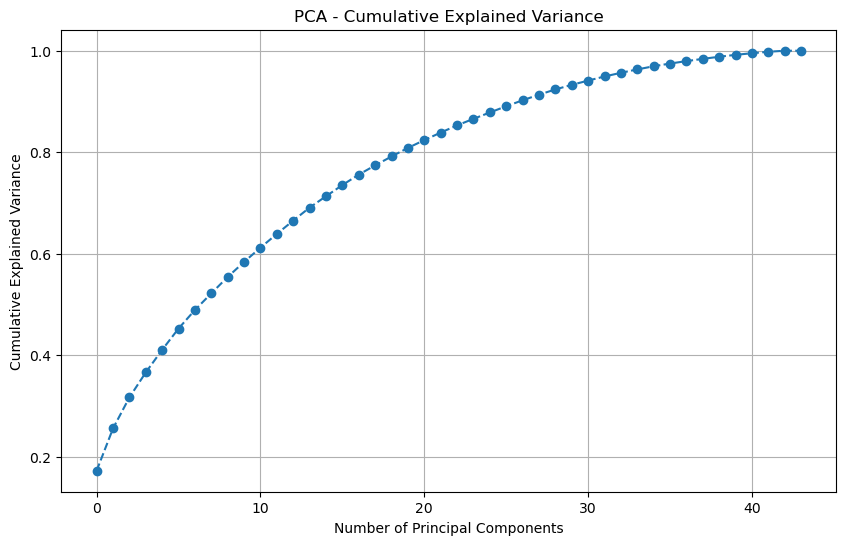

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def process_PCA(df):
    # Extract features and standardize
    features = df.drop(columns='Sensor ID')
    sensor_ids = df['Sensor ID']

    # Standardize the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Perform PCA
    pca = PCA()
    principal_components = pca.fit_transform(features_scaled)

    # Explained variance ratio for each principal component
    explained_variance = pca.explained_variance_ratio_

    # Plot the explained variance to see the importance of each component
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(explained_variance), marker='o', linestyle='--')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA - Cumulative Explained Variance')
    plt.grid(True)
    plt.show()

    # Get the loadings (coefficients) of the features on the principal components
    loadings = pca.components_

    # Display the loadings for the first few principal components
    return explained_variance, loadings, features

explained_variance, loadings, features = process_PCA(df_range_delay_all)



In [29]:
# Create a DataFrame for the loadings
loading_df = pd.DataFrame(loadings.T, columns=[f'PC{i+1}' for i in range(loadings.shape[0])], index=features.columns)
loading_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44
range_delay,,,,,,,,,,,,,,,,,,,,,
13_10000_middle,-0.113093,0.113738,0.126276,0.023264,0.138155,-0.066619,0.050154,0.064267,0.028317,-0.057539,...,-0.006977,-0.000735,0.016461,0.108938,-0.022904,-0.119874,0.046713,0.033688,-0.014205,-0.124914
13_16800_middle,0.015640,0.002834,-0.073999,0.121302,-0.046375,0.130148,0.024770,0.251949,-0.136871,-0.078738,...,0.092123,0.013419,0.069347,0.018184,0.089113,0.116544,0.018321,-0.020211,-0.000624,0.091364
13_3000_middle,-0.141743,-0.176504,0.029821,0.025645,0.122870,-0.028233,0.025960,0.059905,-0.014729,-0.016422,...,0.009423,-0.002410,-0.055037,0.091310,0.009552,-0.030541,0.022802,0.045853,-0.008372,0.392053
13_6000_middle,-0.114688,0.113793,0.126437,0.027154,0.136069,-0.062632,0.046129,0.071641,0.052818,-0.082006,...,-0.008152,0.014899,-0.010643,0.051159,0.034518,-0.035047,-0.028557,0.058569,0.051061,0.345338
13_8000_middle,-0.113227,0.115352,0.125199,0.030819,0.139259,-0.061731,0.050718,0.064009,0.027295,-0.067322,...,-0.019434,0.009988,-0.014369,0.094876,-0.007276,-0.078272,-0.011702,-0.007238,0.053047,-0.059020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53_10000_upper,0.001678,0.041683,0.055296,0.037491,0.009067,0.185934,-0.076392,-0.004849,-0.098834,0.072388,...,0.090333,-0.055440,0.078590,-0.010146,-0.063370,0.063648,0.012460,0.000672,0.094356,0.011466
53_16800_upper,-0.005129,-0.022661,0.149338,0.113070,0.054292,0.044247,0.000111,-0.095645,0.097716,-0.122623,...,0.015769,0.074055,-0.035027,-0.018701,0.150250,-0.014362,0.037603,-0.070277,0.168988,0.080230
53_3000_upper,-0.046604,-0.035001,0.198816,-0.110317,-0.046123,0.016990,-0.011833,0.131101,-0.113297,0.041135,...,-0.075621,0.048414,0.110165,-0.197046,-0.015529,-0.032746,0.027814,-0.080152,0.145949,0.076766


In [30]:
# Determine the number of components to retain 90% variance
cumulative_variance = np.cumsum(explained_variance)
num_components = np.argmax(cumulative_variance >= 0.9) + 1

# Get the loadings for the selected components
selected_loadings = loadings[:num_components, :]

# Calculate the importance of each feature by summing the absolute values of its loadings across the selected components
feature_importance = np.sum(np.abs(selected_loadings), axis=0)

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': feature_importance})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top N features (e.g., top 10 features)
top_features = feature_importance_df.head(50)

top_features

,Feature,Importance
128,48_6000_upper,2.373335
108,28_6000_upper,2.328390
121,43_16800_upper,2.318828
67,33_3000_lower,2.306732
117,38_3000_upper,2.295183
109,28_8000_upper,2.281520
86,53_16800_lower,2.271144
101,23_16800_upper,2.261535
43,53_6000_middle,2.235925
118,38_6000_upper,2.233275


Having many features with an importance score over 1 can be interpreted in various ways.

Implication 1: Distributed Contribution
- Distributed Contribution: When many features have high importance scores, it indicates that the variance in the data is distributed across multiple features rather than being dominated by a few.
- Balanced Influence: This suggests a balanced influence where no single feature overwhelmingly explains the variance, but rather, multiple features contribute significantly.

Implication 2: Multicollinearity
- Multicollinearity: It might indicate the presence of multicollinearity, where multiple features are correlated with each other and together contribute to the same principal components.
- Redundancy: In such cases, there might be redundancy in the information provided by these features



To address these issues we could look into correlation matrix and use regularization technique to reduce it

## Investigate Multicollinearity

### Analyze using correlation matrix

In [31]:
# List of DataFrames
df_pivots = [df_range_delay_lower, df_range_delay_upper]

# Initialize the merged DataFrame with the first DataFrame in the list
df_range_delay_ends = df_pivots[0]

# Iteratively merge each DataFrame in the list
for df in df_pivots[1:]:
    df_range_delay_ends = df_range_delay_ends.merge(df, on='Sensor ID')
# Replace all NaN values with 0 in the merged DataFrame
df_range_delay_ends.fillna(0, inplace=True)

In [32]:
df_range_delay_corr= df_range_delay_ends.drop(["Sensor ID"], axis = 1)

In [33]:
# Calculate the correlation matrix for the dataset
correlation_matrix = df_range_delay_corr.corr()
correlation_matrix


range_delay,13_10000_lower,13_16800_lower,13_3000_lower,13_6000_lower,13_8000_lower,18_10000_lower,18_16800_lower,18_3000_lower,18_6000_lower,18_8000_lower,...,48_10000_upper,48_16800_upper,48_3000_upper,48_6000_upper,48_8000_upper,53_10000_upper,53_16800_upper,53_3000_upper,53_6000_upper,53_8000_upper
range_delay,,,,,,,,,,,,,,,,,,,,,
13_10000_lower,1.000000,-0.091656,0.063831,0.309296,0.355861,0.079880,0.139725,-0.060398,0.045628,0.026232,...,-0.171667,-0.000212,-0.025483,-0.144026,-0.063180,-0.064994,0.180788,0.047182,-0.195133,-0.272788
13_16800_lower,-0.091656,1.000000,0.137054,-0.037645,-0.039072,0.306314,0.075860,0.234089,0.022127,-0.151840,...,-0.080295,0.100179,0.245485,0.028990,0.033704,0.019967,-0.158319,0.045088,0.212463,0.038337
13_3000_lower,0.063831,0.137054,1.000000,0.389244,0.442770,-0.104270,0.471812,0.158543,-0.045717,-0.077926,...,0.016345,0.154905,-0.183083,0.164627,0.035815,0.222982,0.275764,0.165344,0.335483,0.064820
13_6000_lower,0.309296,-0.037645,0.389244,1.000000,0.387523,-0.182640,0.174118,-0.032812,-0.041698,-0.239167,...,-0.071070,-0.265835,-0.088454,-0.024527,0.020678,-0.165158,0.192713,0.194983,0.145467,0.020743
13_8000_lower,0.355861,-0.039072,0.442770,0.387523,1.000000,0.058465,0.200300,0.094236,0.014509,-0.043468,...,0.019238,0.058351,-0.098248,-0.183538,-0.160564,0.010981,0.218573,0.000136,0.099435,-0.105986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53_10000_upper,-0.064994,0.019967,0.222982,-0.165158,0.010981,0.189476,0.129109,0.173669,0.033477,0.336398,...,-0.001927,0.195831,-0.225441,0.174078,-0.044446,1.000000,-0.089542,0.121351,0.133472,0.397365
53_16800_upper,0.180788,-0.158319,0.275764,0.192713,0.218573,-0.132011,0.058296,-0.153166,-0.031599,0.032942,...,-0.241094,0.382657,-0.101572,-0.019658,-0.127486,-0.089542,1.000000,0.026740,0.393628,0.245825
53_3000_upper,0.047182,0.045088,0.165344,0.194983,0.000136,0.096981,0.015841,0.132881,-0.066987,0.231460,...,0.220863,0.010839,0.107624,0.363440,0.432326,0.121351,0.026740,1.000000,0.127172,0.157560


In [34]:
# Extract pairs of highly correlated features with correlation coefficient above a threshold (e.g., 0.8 or below -0.8)
threshold = 0.7
highly_correlated_pairs = []

for i in range(correlation_matrix.shape[0]):
    for j in range(i+1, correlation_matrix.shape[1]):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            feature_pair = (correlation_matrix.index[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j])
            highly_correlated_pairs.append(feature_pair)

# Convert the list of tuples to a DataFrame for better readability
highly_correlated_df = pd.DataFrame(highly_correlated_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
highly_correlated_df


,Feature 1,Feature 2,Correlation
0,13_8000_lower,13_8000_upper,0.731078
1,53_3000_lower,53_3000_upper,0.700486


In [35]:
def drop_highly_correlated_features(df, threshold=0.8):
    """
    Drops highly positively correlated features from a DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    threshold (float): The correlation threshold for dropping features. Defaults to 0.8.
    
    Returns:
    pd.DataFrame: DataFrame with highly positively correlated features removed.
    list: List of dropped features.
    """
    # Calculate the correlation matrix
    corr_matrix = df.corr()
    
    # Identify highly positively correlated pairs
    to_drop = set()
    for i in range(corr_matrix.shape[0]):
        for j in range(i + 1, corr_matrix.shape[1]):
            if corr_matrix.iloc[i, j] > threshold:
                colname = corr_matrix.columns[j]
                to_drop.add(colname)
    
    # Drop the identified features
    reduced_df = df.drop(columns=to_drop)
    
    return reduced_df, list(to_drop)

# Apply the function to the dataset
reduced_data_corr, dropped_features_corr = drop_highly_correlated_features(df_range_delay_ends, threshold=0.7)

reduced_data_corr

range_delay,Sensor ID,13_10000_lower,13_16800_lower,13_3000_lower,13_6000_lower,13_8000_lower,18_10000_lower,18_16800_lower,18_3000_lower,18_6000_lower,...,43_8000_upper,48_10000_upper,48_16800_upper,48_3000_upper,48_6000_upper,48_8000_upper,53_10000_upper,53_16800_upper,53_6000_upper,53_8000_upper
0,32,0.000000,741.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1047.000000,0.000000,...,2515.444444,0.000000,0.000000,2787.833333,0.000000,0.000000,3099.000000,0.000000,0.000000,0.000000
1,33,754.402299,755.000000,0.000000,755.307692,747.000000,0.000000,0.000000,0.000000,0.000000,...,2479.500000,0.000000,0.000000,2740.037037,0.000000,0.000000,0.000000,3073.666667,3073.400000,3074.000000
2,34,0.000000,0.000000,653.285714,0.000000,0.000000,0.000000,944.473684,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,35,0.000000,0.000000,0.000000,0.000000,862.151515,1003.000000,0.000000,0.000000,0.000000,...,2477.698795,2758.652174,0.000000,2756.839080,0.000000,2778.428571,0.000000,0.000000,0.000000,0.000000
4,36,0.000000,0.000000,0.000000,0.000000,0.000000,1066.244444,0.000000,1055.000000,1066.105263,...,0.000000,2779.000000,0.000000,0.000000,0.000000,0.000000,3113.000000,0.000000,0.000000,0.000000
5,37,715.000000,0.000000,731.000000,0.000000,731.000000,0.000000,0.000000,0.000000,0.000000,...,2456.600000,2720.523810,2679.000000,2720.063291,2743.285714,2743.000000,3075.000000,3046.666667,3041.153846,2241.333333
6,38,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1028.000000,...,2435.423529,0.000000,0.000000,0.000000,0.000000,0.000000,3063.000000,0.000000,0.000000,1862.333333
7,39,0.000000,866.148936,866.148936,0.000000,0.000000,1070.435294,1070.670588,1070.645570,1070.703704,...,2463.000000,0.000000,2719.727273,2696.185185,2696.234568,2695.911392,2994.340206,3023.000000,3023.000000,2993.408163
8,40,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1035.000000,...,0.000000,2763.769231,2739.987654,0.000000,0.000000,2771.000000,0.000000,3051.640000,3050.333333,0.000000
9,41,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1010.157895,1012.454545,0.000000,...,0.000000,2753.782609,0.000000,0.000000,2753.153846,2752.714286,3053.000000,0.000000,3029.168675,3053.476190


In [36]:
dropped_features_corr

['53_3000_upper', '13_8000_upper']

In [37]:
def plot_pca_interactive(data, sensor_id_col='Sensor ID', n_components=2):
    """
    Plots an interactive scatter plot using PCA components.

    Parameters:
    data (pd.DataFrame): The input DataFrame containing features and Sensor ID.
    sensor_id_col (str): The name of the column containing sensor IDs.
    n_components (int): Number of principal components to compute.

    Returns:
    None: Displays an interactive Plotly scatter plot.
    """
    # Apply PCA
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(data.drop(columns=[sensor_id_col]))

    # Create a DataFrame with the principal components and Sensor ID
    principal_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])
    principal_df[sensor_id_col] = data[sensor_id_col]

    # Create an interactive scatter plot using Plotly
    fig = px.scatter(
        principal_df,
        x='PC1',
        y='PC2',
        color=sensor_id_col,
        title='Sensors Visualized Using Principal Components',
        labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2'},
        hover_data=[sensor_id_col]
    )

    # Show the plot
    fig.show()

In [38]:
# Plot the PCA interactive plot
plot_pca_interactive(df_range_delay_ends, sensor_id_col='Sensor ID', n_components=2)

Try PCA on reduced data

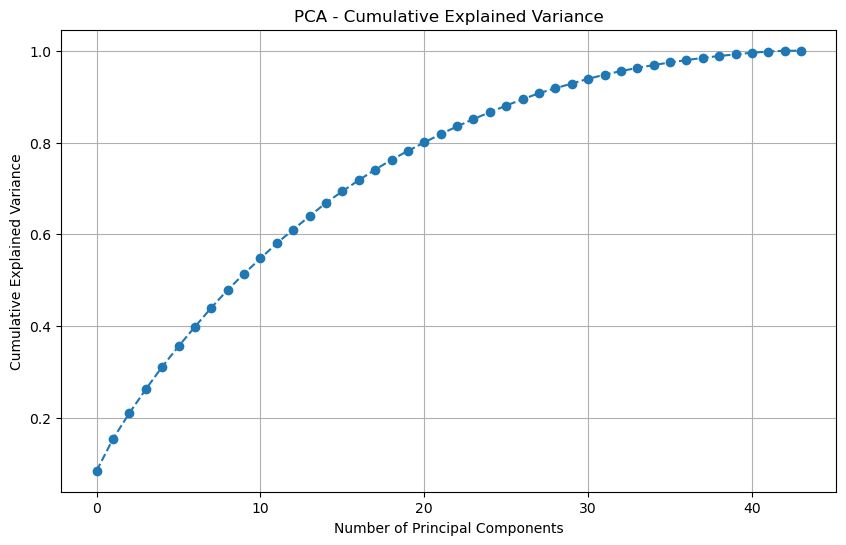

In [39]:
explained_variance_corr, loadings_corr, features_corr = process_PCA(reduced_data_corr)

In [40]:
# Create a DataFrame for the loadings
loading_df_corr = pd.DataFrame(loadings_corr.T, columns=[f'PC{i+1}' for i in range(loadings_corr.shape[0])], index=features_corr.columns)
loading_df_corr

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44
range_delay,,,,,,,,,,,,,,,,,,,,,
13_10000_lower,0.012515,0.075785,0.178538,-0.015022,0.018133,0.091393,0.093010,0.056118,0.063775,0.063213,...,0.109069,0.288093,-0.078824,-0.118301,-0.034338,-0.079413,-0.010353,-0.159203,-0.097897,0.181414
13_16800_lower,0.085003,0.034685,0.082188,-0.129187,-0.143437,-0.056636,0.058686,-0.038639,-0.075581,-0.033288,...,0.018781,0.115061,-0.048025,0.018001,0.109772,0.230352,-0.019326,-0.068940,-0.096993,0.368895
13_3000_lower,0.184595,0.215630,-0.046248,-0.056324,-0.040533,0.077118,-0.076838,0.111500,0.005962,0.056313,...,0.005478,-0.013635,-0.182113,0.084389,-0.064611,0.069340,0.111329,0.022287,-0.010525,-0.106709
13_6000_lower,0.063267,0.173413,-0.023608,-0.234535,0.020402,0.150094,0.026739,-0.043895,-0.060016,0.151052,...,-0.081606,0.028635,0.032046,-0.132828,-0.080104,0.045267,-0.070072,-0.174624,0.063192,-0.006690
13_8000_lower,0.057570,0.168437,0.132001,-0.002814,-0.140396,0.132622,0.064632,-0.033019,0.006123,0.102637,...,-0.051680,-0.082044,0.141441,-0.142714,0.059118,0.112400,-0.008998,-0.051050,0.046277,0.090741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48_8000_upper,0.055529,-0.074559,0.045541,-0.053186,-0.066203,-0.152676,-0.282747,-0.038742,-0.152741,0.021464,...,-0.050449,0.049503,-0.036895,0.036577,-0.008075,0.103110,0.005012,-0.072982,-0.032012,-0.039200
53_10000_upper,0.042964,0.041093,-0.107216,0.147488,-0.072788,0.090331,-0.031851,0.196465,-0.240411,-0.066374,...,0.064212,0.004928,0.021262,-0.147112,-0.076308,0.001598,-0.049306,0.027535,0.217139,-0.045575
53_16800_upper,0.144981,0.110035,0.000320,0.073700,0.085964,-0.094514,0.259420,-0.070585,0.005620,0.012917,...,-0.031692,0.017554,-0.052616,0.193125,0.148870,-0.092240,-0.155639,0.156962,0.000289,0.018752


In [41]:
# Determine the number of components to retain 90% variance
cumulative_variance = np.cumsum(explained_variance_corr)
num_components = np.argmax(cumulative_variance >= 0.9) + 1

# Get the loadings for the selected components
selected_loadings_corr = loadings_corr[:num_components, :]

# Calculate the importance of each feature by summing the absolute values of its loadings across the selected components
feature_importance_corr = np.sum(np.abs(selected_loadings_corr), axis=0)

# Create a DataFrame for feature importance
feature_importance_df_corr = pd.DataFrame({'Feature': features_corr.columns, 'Importance': feature_importance_corr})

# Sort the features by importance
feature_importance_df_corr = feature_importance_df_corr.sort_values(by='Importance', ascending=False)

# Select the top N features (e.g., top 10 features)
top_features_corr = feature_importance_df_corr.head(200)

top_features_corr

,Feature,Importance
35,48_10000_lower,2.897291
55,23_16800_upper,2.855303
22,33_3000_lower,2.850252
37,48_3000_lower,2.809336
8,18_6000_lower,2.766342
...,...,...
10,23_10000_lower,2.109517
3,13_6000_lower,2.091893
14,23_8000_lower,2.064383
2,13_3000_lower,2.012307


In [42]:
# Plot the PCA interactive plot
plot_pca_interactive(reduced_data_corr, sensor_id_col='Sensor ID', n_components=2)

## Clustering

In [45]:
from sklearn.cluster import KMeans

# Apply PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(reduced_data_corr.drop(columns=['Sensor ID']))
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
principal_df['Sensor ID'] = reduced_data_corr['Sensor ID']

# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
principal_df['Cluster'] = kmeans.fit_predict(principal_df[['PC1', 'PC2', 'PC3']])

# Create an interactive 3D scatter plot
fig = px.scatter_3d(
    principal_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Cluster',
    symbol='Sensor ID',
    title='K-Means Clustering of Sensors Using PCA',
    labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2', 'PC3': 'Principal Component 3'},
    hover_data=['Sensor ID']
)

fig.show()

c:\Anaconda\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Anaconda\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

